In [1]:
train_data = './data/train'
train_labels = './data/train.csv'
val_data = './data/val'
val_labels = './data/val.csv'

In [4]:
from utilities import GestureDataGenerator, plot_training_history, set_seed, get_callbacks, checks_and_balances
checks_and_balances()
set_seed(seed=42)

Mixed precision is enabled with policy 'mixed_float16'. GPU compute capability: 8.9
Random seed set to 42


In [5]:
load_fraction = 1.0             # Full data load
batch_size = 16                 # We are low on resources. We will go slow and steady.
image_size = (120, 120)

# Initialize the generator
train_generator = GestureDataGenerator(
    data_path=train_data,
    labels_csv=train_labels,
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True,
    load_fraction=load_fraction,
    debug=False,
    use_mediapipe=False,
)

val_generator = GestureDataGenerator(
    data_path=val_data,
    labels_csv=val_labels,
    batch_size=batch_size,
    image_size=image_size,
    augmentations=None,
    shuffle=False,
    load_fraction=1.0,
    debug=False,
    use_mediapipe=False,
)

# Get the first batch
X, y = train_generator[0]

# Print outputs
print("Input batch shape (X):", X.shape)  # Expected shape: (batch_size, sequence_length, 224, 224, 3)
print("Labels batch shape (y):", y.shape)  # Expected shape: (batch_size, num_classes)
print("First label in batch (one-hot):", y[0])

42 batches created, each of size 16, with 663 sequences of 30 images each. Use MediaPipe: False
7 batches created, each of size 16, with 100 sequences of 30 images each. Use MediaPipe: False
Input batch shape (X): (16, 30, 120, 120, 3)
Labels batch shape (y): (16, 5)
First label in batch (one-hot): [0. 0. 0. 1. 0.]


In [7]:
# Define parameters
sequence_length = train_generator.sequence_length  # Frames per video (from generator)
image_size = train_generator.image_size            # Image size (height, width)
num_classes = train_generator.num_classes          # Number of gesture classes
input_shape = (sequence_length, image_size[0], image_size[1], 3)  # Conv3D input shape

In [8]:
from tensorflow.keras import layers, models, regularizers

# Define the model
model = models.Sequential([
    # Input layer
    layers.Input(shape=(sequence_length, None, None, 3)),  # Input shape: (timesteps, height, width, channels)

    # Smaller CNN layers for feature extraction
    layers.TimeDistributed(layers.Conv2D(16, (3, 3), activation='relu', padding='same')),
    layers.TimeDistributed(layers.BatchNormalization()),
    layers.TimeDistributed(layers.MaxPooling2D(pool_size=(2, 2), padding='same')),

    layers.TimeDistributed(layers.Conv2D(32, (3, 3), activation='relu', padding='same')),
    layers.TimeDistributed(layers.BatchNormalization()),
    layers.TimeDistributed(layers.MaxPooling2D(pool_size=(2, 2), padding='same')),

    layers.TimeDistributed(layers.Conv2D(64, (3, 3), activation='relu', padding='same')),
    layers.TimeDistributed(layers.BatchNormalization()),
    layers.TimeDistributed(layers.MaxPooling2D(pool_size=(2, 2), padding='same')),

    # Global average pooling to reduce parameters
    layers.TimeDistributed(layers.GlobalAveragePooling2D()),

    # RNN layer for temporal modeling
    layers.Bidirectional(layers.GRU(32, return_sequences=False, recurrent_activation='sigmoid')),  # cuDNN-compatible configuration

    # Fully connected layers
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # L2 regularization
    layers.Dropout(0.5),

    # Output layer
    layers.Dense(num_classes, activation='softmax')  # Softmax for multi-class classification
])

# Compile the model
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, None, None, 1  448      
 ibuted)                     6)                                  
                                                                 
 time_distributed_1 (TimeDis  (None, 30, None, None, 1  64       
 tributed)                   6)                                  
                                                                 
 time_distributed_2 (TimeDis  (None, 30, None, None, 1  0        
 tributed)                   6)                                  
                                                                 
 time_distributed_3 (TimeDis  (None, 30, None, None, 3  4640     
 tributed)                   2)                                  
                                                                 
 time_distributed_4 (TimeDis  (None, 30, None, None, 3  

In [10]:
model_save_location = './best-models/Conv2D+LSTM'

In [44]:
checkpoint_callback, reduce_lr_callback, early_stopping_callback = get_callbacks(filepath = model_save_location, lr_factor=0.8)

Epoch 1/100
42/42 [==============================] - 36s 784ms/step - loss: 2.0792 - accuracy: 0.3454 - val_loss: 2.1531 - val_accuracy: 0.2100 - lr: 0.0010
Epoch 2/100
42/42 [==============================] - 32s 757ms/step - loss: 1.7250 - accuracy: 0.4676 - val_loss: 2.2836 - val_accuracy: 0.2100 - lr: 0.0010
Epoch 3/100
42/42 [==============================] - 32s 753ms/step - loss: 1.5275 - accuracy: 0.5249 - val_loss: 2.6890 - val_accuracy: 0.2100 - lr: 0.0010
Epoch 4/100
42/42 [==============================] - 32s 761ms/step - loss: 1.3377 - accuracy: 0.5716 - val_loss: 2.9256 - val_accuracy: 0.2100 - lr: 0.0010
Epoch 5/100
42/42 [==============================] - 32s 771ms/step - loss: 1.2332 - accuracy: 0.6456 - val_loss: 2.7366 - val_accuracy: 0.2100 - lr: 0.0010
Epoch 6/100
42/42 [==============================] - ETA: 0s - loss: 1.1814 - accuracy: 0.6501
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.
42/42 [==============================] - 32s 

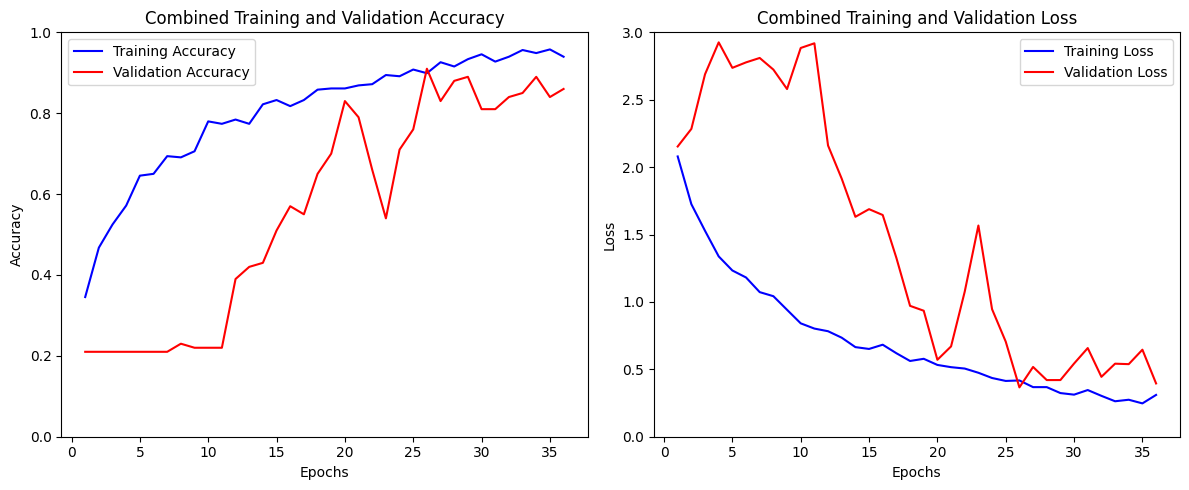

In [45]:
# Train the model
history_1 = model.fit(
    x=train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=[checkpoint_callback, reduce_lr_callback, early_stopping_callback],
    verbose=1
)

plot_training_history(histories=[history_1])

In [46]:
# model.load_weights(model_save_location)

# # Train the model for more epochs
# history_2 = model.fit(
#     x=train_generator,
#     validation_data=val_generator,
#     epochs=30,                  # Train for more epochs
#     initial_epoch=5,            # Start counting previous epochs
#     callbacks=[checkpoint_callback, reduce_lr_callback, early_stopping_callback],
#     verbose=1
# )

# plot_training_history(histories=[history_1, history_2])

In [47]:
# model.load_weights(model_save_location)

# # Train the model for more epochs
# history_3 = model.fit(
#     x=train_generator,
#     validation_data=val_generator,
#     epochs=50,                   # Train for more epochs
#     initial_epoch=30,            # Start counting previous epochs
#     callbacks=[checkpoint_callback, reduce_lr_callback, early_stopping_callback],
#     verbose=1
# )

# plot_training_history(histories=[history_1, history_2, history_3])

In [11]:
model.load_weights(f'{model_save_location}.h5')

evaluation_results = model.evaluate(val_generator, verbose=1)

for metric, value in zip(model.metrics_names, evaluation_results):
    print(f"{metric}: {value:.4f}")

7/7 [==============================] - 6s 658ms/step - loss: 0.3660 - accuracy: 0.9100
loss: 0.3660
accuracy: 0.9100


In [12]:
model.load_weights(f'{model_save_location}.h5')

evaluation_results = model.evaluate(train_generator, verbose=1)

for metric, value in zip(model.metrics_names, evaluation_results):
    print(f"{metric}: {value:.4f}")

42/42 [==============================] - 27s 637ms/step - loss: 0.3299 - accuracy: 0.9201
loss: 0.3299
accuracy: 0.9201
